# RIDERneuro T1 mapping

In [1]:
import sys
sys.path.insert(0, '../src')

In [49]:
import original.T1_mapping.MJT_EdinburghUK.t1 as edinburgh
import original.T1_mapping.ST_SydneyAus.VFAT1mapping as sydney
import original.T1_mapping.McGill.vfa as mcgill
import matplotlib.pyplot as plt
import os
import json
import re
import urllib.request
import nibabel as nib
import mat73
import numpy as np
from numpy.linalg import norm

plt.style.use('https://gist.github.com/notZaki/8bfb049230e307f4432fd68d24c603a1/raw/c0baa2a1c55afdf1764b26ee2ebeb1cbf26d8d98/pltstyle')

In [68]:
def remove_leading_slash(pathstring):
    if pathstring[0] == "/":
        return pathstring[1:]
    else:
        return pathstring


def make_folder_for(file):
    folder = os.path.dirname(file)
    if not os.path.isdir(folder):
        os.makedirs(folder)
    return


def get_manifest(manifestfile, manifesturl = "https://osf.io/nx5jw/download"):
    if not os.path.isfile(manifestfile):
        urllib.request.urlretrieve(manifesturl, manifestfile)
    with open(manifestfile) as iostream:
        manifest = json.load(iostream)
    return manifest


def get_rider(subjectid, session, filetype, datafolder = "./data"):
    # subjectid in ["01" to "19"]
    # session in [1 or 2]
    # filetype in [VFA, GRE, perf, mask]

    # Download/get manifest
    if not os.path.isdir(datafolder): 
        os.makedirs(datafolder)
    manifestfile = os.path.join(datafolder, "RIDERmanifest.json")
    manifest = get_manifest(manifestfile)

    # Find key in manifest
    matchedkeys = []
    for key in manifest.keys():
        if (f"sub-{subjectid}" in key) and (f"ses-{session}" in key) and (filetype in key):
            matchedkeys.append(key)

    # Download/get files
    files = []
    for key in matchedkeys:
        fileurl = manifest[key]
        filepath = os.path.join(datafolder, remove_leading_slash(key))
        make_folder_for(filepath)
        if not os.path.isfile(filepath):
            urllib.request.urlretrieve(fileurl, filepath)
        files.append(filepath)
        
    return files

def get_flip_angle(filename):
    return int(re.search("flip(.*?)_VFA", filename).group(1))

def get_nifti_data(filename):
    return nib.load(filename).get_fdata()

def get_tr(filename):
    return nib.load(filename).header.get_zooms()[-1]

In [124]:
# def show_fits(fittedM0, fittedT1, truthdata = t1data):
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
#     ax1.imshow(fittedM0)
#     ax1.grid(False)
#     plt.sca(ax1)
#     plt.title("M0")
#     plt.xticks(np.arange(5, 150, 10), np.round((np.unique(truthdata.T1))).astype(int), rotation=45, ha="right")
#     plt.yticks(np.arange(5, 70, 10), np.round((np.unique(truthdata.M0))).astype(int))
    
#     ax2.imshow(fittedT1)
#     ax2.grid(False)
#     plt.sca(ax2)
#     plt.title("T1")
#     plt.xticks(np.arange(5, 150, 10), np.round((np.unique(truthdata.T1))).astype(int), rotation=45, ha="right")
#     plt.yticks(np.arange(5, 70, 10), np.round((np.unique(truthdata.M0))).astype(int))
    
#     fig.tight_layout()
#     return

def percenterror(estimated, truth):
    return 100 * (estimated - truth) / truth

def vfa_fit(_signal, _fa, _tr, author, fittype = "linear", mask = None):
    # Signal: numpy array, last dimension must be flip angle
    # fa: flip angles, in radian
    # tr: repetition time, in ms
    
    spatialdims = _signal.shape[:-1]
    signal = _signal.reshape(-1, _signal.shape[-1])
    if mask != None:
        signal = signal[mask[:] > 0, :]
        
    if author == "edinburgh":
        fa = _fa
        tr = _tr
        if fittype == "nonlinear":
            _M0, _T1 = edinburgh.fit_vfa_nonlinear(signal, fa, tr)
        else: # linear
            _M0, _T1 = edinburgh.fit_vfa_linear(signal, fa, tr)
    elif author == "sydney":
        fa = np.rad2deg(_fa)
        tr = _tr
        numvox = np.prod(spatialdims)
        _M0 = np.zeros(numvox)
        _T1 = np.zeros(numvox)
        for idx in range(numvox):
            _M0[idx], _T1[idx] = sydney.VFAT1mapping(fa, signal[idx, :], tr, method = fittype)
    elif author == "mcgill":
        fa = _fa
        tr = _tr
        if fittype == "nonlinear":
            _M0, _T1 = mcgill.novifast(signal, fa, tr, initialvalues=[10000, 3000])
        elif fittype == "nonlinear_noniterative":
            _M0, _T1 = mcgill.novifast(signal, fa, tr, doiterative = False)
        else: # linear
            _M0, _T1 = mcgill.despot(signal, fa, tr)
    else:
        print("ERROR: Unexpected author")
        return
    
    if mask != None:
        M0 = np.zeros(spatialdims)
        T1 = np.zeros(spatialdims)
        M0[mask[:] > 0] = _M0
        T1[mask[:] > 0] = _T1
    else:
        M0 = _M0.reshape(spatialdims)
        T1 = _T1.reshape(spatialdims)
    return (M0, T1)

In [118]:
vfafiles = get_rider(subjectid = "01", session = "1", filetype = "VFA.nii.gz")

In [133]:
signal = np.stack([get_nifti_data(file) for file in vfafiles], axis = -1)
flipangles = np.array([get_flip_angle(file) for file in vfafiles])
tr = 4.43

In [157]:
%%time
fittedM0, fittedT1 = vfa_fit(signal, np.deg2rad(flipangles), tr, author = "edinburgh", fittype = "linear")

CPU times: user 1min 10s, sys: 677 ms, total: 1min 11s
Wall time: 1min 10s


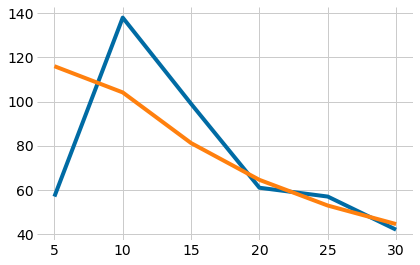

In [158]:
tmpM0 = fittedM0[100,100,8]
tmpT1 = fittedT1[100,100,8]
fa = np.deg2rad(flipangles)
E = np.exp(-tr/tmpT1)
tmpS = tmpM0 * np.sin(fa) * (1 - E) / (1 - np.cos(fa) * E)

plt.plot(flipangles, signal[100,100,8,:])
plt.plot(flipangles, tmpS)

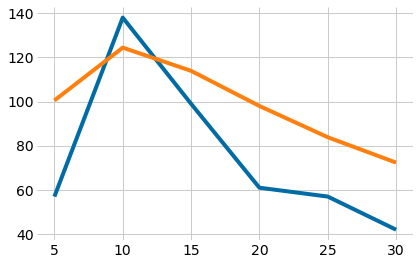

In [155]:
tmpM0 = fittedM0[100,100,8]
tmpT1 = 300
fa = np.deg2rad(flipangles)
E = np.exp(-tr/tmpT1)
tmpS = tmpM0 * np.sin(fa) * (1 - E) / (1 - np.cos(fa) * E)

plt.plot(flipangles, signal[100,100,8,:])
plt.plot(flipangles, tmpS)

In [148]:
fittedT1[100,100,8]

802.9706143162192

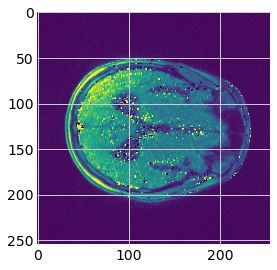

In [146]:
plt.imshow(fittedM0[:,:,8], clim=(0, 10000))

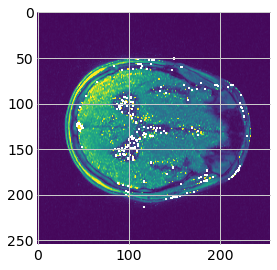

In [159]:
plt.imshow(fittedM0[:,:,8], clim=(0, 10000))

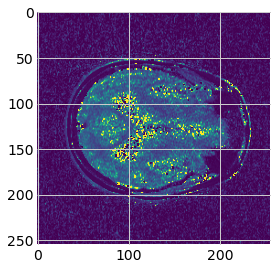

In [147]:
plt.imshow(fittedT1[:,:,8], clim=(200, 1500))

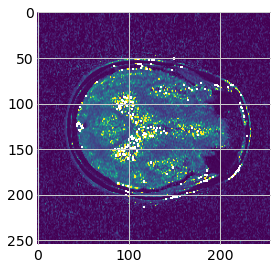

In [160]:
plt.imshow(fittedT1[:,:,8], clim=(200, 1500))

In [91]:
%%time 
fittedM0, fittedT1 =  vfa_fit(signal, np.deg2rad(flipangles), tr, author = "edinburgh", fittype = "linear")

CPU times: user 831 ms, sys: 75.2 ms, total: 906 ms
Wall time: 837 ms


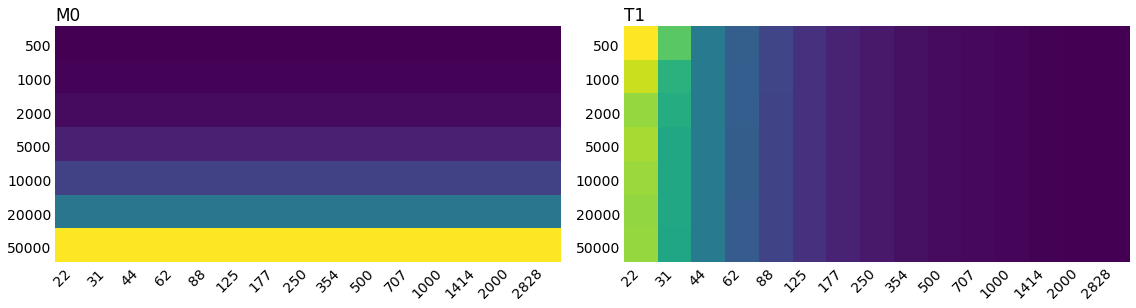

In [19]:
%%time 
fittedM0, fittedT1 =  vfa_fit(t1data.signal, t1data.fa, t1data.TR, author = "edinburgh", fittype = "linear")
show_fits(fittedM0, fittedT1); 

CPU times: user 19.7 s, sys: 0 ns, total: 19.7 s
Wall time: 19.7 s


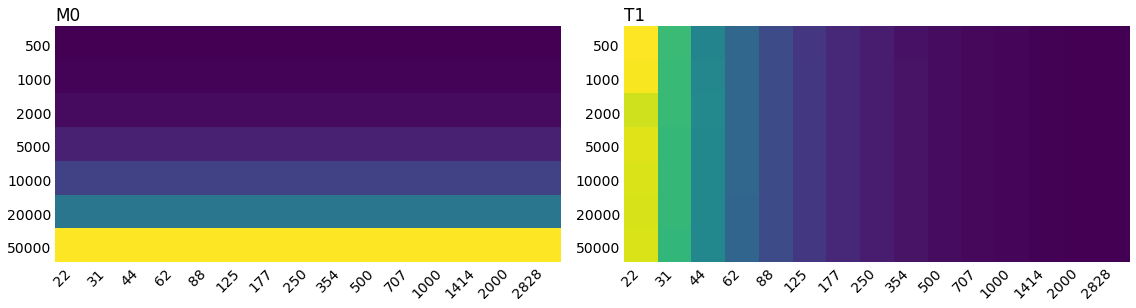

In [20]:
%%time
fittedM0, fittedT1 =  vfa_fit(t1data.signal, t1data.fa, t1data.TR, author = "edinburgh", fittype = "nonlinear")
show_fits(fittedM0, fittedT1)

CPU times: user 35.8 s, sys: 11.5 ms, total: 35.8 s
Wall time: 35.8 s


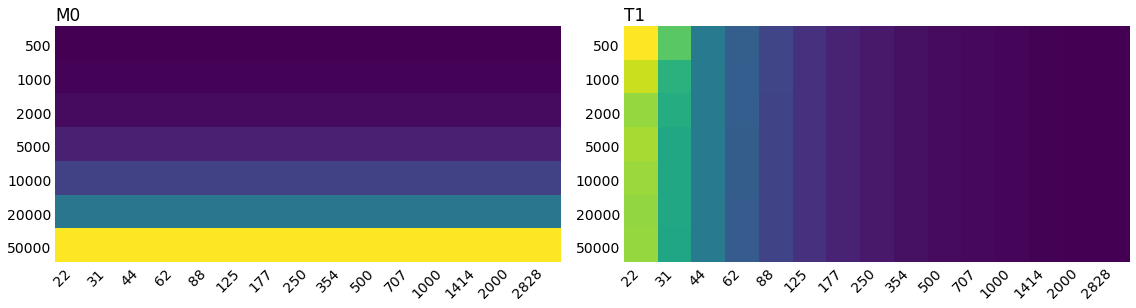

In [21]:
%%time
fittedM0, fittedT1 =  vfa_fit(t1data.signal, t1data.fa, t1data.TR, author = "sydney", fittype = "linear")
show_fits(fittedM0, fittedT1)

CPU times: user 53.4 s, sys: 41.1 ms, total: 53.4 s
Wall time: 53.4 s


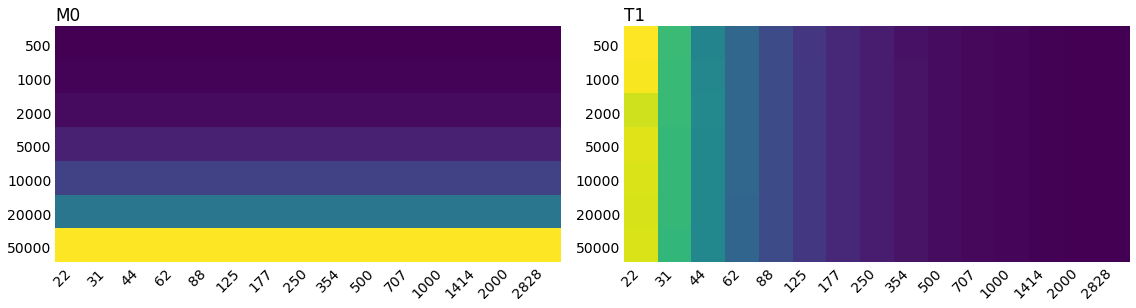

In [22]:
%%time 
fittedM0, fittedT1 =  vfa_fit(t1data.signal, t1data.fa, t1data.TR, author = "sydney", fittype = "nonlinear")
show_fits(fittedM0, fittedT1)

CPU times: user 126 ms, sys: 5.07 ms, total: 131 ms
Wall time: 130 ms


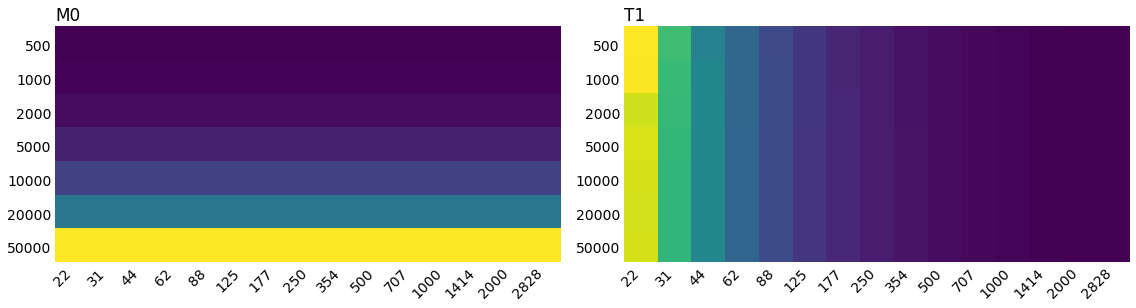

In [23]:
%%time
fittedM0, fittedT1 = vfa_fit(t1data.signal, t1data.fa, t1data.TR, author = "mcgill", fittype = "nonlinear")
show_fits(fittedM0, fittedT1)

CPU times: user 94.9 ms, sys: 6.1 ms, total: 101 ms
Wall time: 99.6 ms


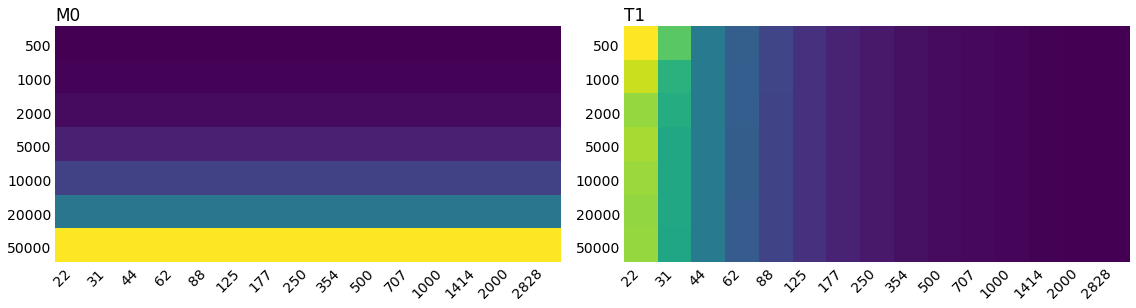

In [24]:
%%time
fittedM0, fittedT1 = vfa_fit(t1data.signal, t1data.fa, t1data.TR, author = "mcgill", fittype = "linear")
show_fits(fittedM0, fittedT1)